In [129]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

In [148]:
region = pd.read_csv('region_v2.csv')[['HDONG_NM','resident','tourism']]
flow_age = pd.read_csv('TOTAL_FLOW_AGE_MELT.csv')
flow_time = pd.read_csv('SK_melted_flow_time.csv')

In [149]:
refl = pd.merge(flow_age,region,on="HDONG_NM")

reti = pd.merge(flow_time,region,on='HDONG_NM')

In [150]:
refl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498870 entries, 0 to 498869
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   STD_YM    498870 non-null  int64  
 1   STD_YMD   498870 non-null  object 
 2   HDONG_CD  498870 non-null  int64  
 3   HDONG_NM  498870 non-null  object 
 4   age       498870 non-null  object 
 5   FLOW      498870 non-null  float64
 6   YEAR      498870 non-null  int64  
 7   MONTH     498870 non-null  int64  
 8   WEEK_NUM  498870 non-null  int64  
 9   WEEKDAY   498870 non-null  int64  
 10  weekday   498870 non-null  object 
 11  SEX_CD    498870 non-null  object 
 12  AGE_CD    498870 non-null  object 
 13  resident  498870 non-null  int64  
 14  tourism   498870 non-null  int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 60.9+ MB


In [151]:
resident = pd.merge(region.query('resident == 1')[['HDONG_NM']],flow_age,on='HDONG_NM',how='left')
tourism = pd.merge(region.query('tourism == 1')[['HDONG_NM']],flow_age,on='HDONG_NM',how='left')

In [152]:
def graph_by_weeknum(category_name):
    # 지역별 주별 평균을 구하고 -> 이것을 업종별로 합해서 그 업종 추이를 보고자 하였다
    df = refl.query('{} == 1'.format(category_name)).groupby(['YEAR','HDONG_NM','WEEK_NUM'])[['FLOW']].mean().reset_index()
    df = df.groupby(['YEAR','WEEK_NUM'])[['FLOW']].sum().reset_index()
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='WEEK_NUM', y='FLOW', hue='YEAR', data=df, palette="Set2")
    ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    ax.legend([2019, 2020])
    ax.axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
    ax.axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
    ax.set_ylim([0, df['FLOW'].max()*1.1])
    ax.text(x=max_date_num_week, 
         y=df.query('YEAR==2020')['FLOW'].min(), 
         s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
         fontsize=12)
    ax.text(x=disaster_support_date_num_week, 
         y=df.query('YEAR==2020')['FLOW'].min(), 
         s='　재난지원금\n　(2020.05.13)',
         fontsize=12)
    ax.set_title("주차별 {} 유동인구".format(category_name), fontsize=12)
    
def graph_by_weeknum_with_hue(category_name, aggregate_column, hue_column):
    df = refl.query('{} == 1'.format(category_name)).groupby(['YEAR', 'WEEK_NUM', 'HDONG_NM','SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    df = df.groupby(['YEAR','WEEK_NUM',hue_column])[[aggregate_column]].sum().reset_index()
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    year_2019_df = df.loc[df['YEAR']==2019, :]
    year_2020_df = df.loc[df['YEAR']==2020, :]

    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]
    hue_columns = list(set(df[hue_column]))
    hue_columns.sort()
    len_rows = len(set(df[hue_column]))

    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2019_df, palette="Set2", ax=axes[0])
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2020_df, palette="Set2", ax=axes[1])
    for i in [0, 1]:
        year = 2019 if i==0 else 2020
        axes[i].set_ylim([0, df[aggregate_column].max()*1.1])
        axes[i].legend(loc='lower left')
        axes[i].set_xticks(list(set(df['WEEK_NUM'])))
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title("{}년도".format(year))

    fig, axes = plt.subplots(nrows=len_rows, figsize=(16, 5*len_rows))
    for i, select in enumerate(hue_columns):
        temp_2019 = year_2019_df.loc[year_2019_df[hue_column]==select, :]
        temp_2020 = year_2020_df.loc[year_2020_df[hue_column]==select, :]

        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2019, ax=axes[i], palette='Set2')
        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2020, ax=axes[i], palette='Set2')
        axes[i].set_ylim(0, max([temp_2019[aggregate_column].max(), temp_2020[aggregate_column].max()])*1.1)
        axes[i].set_xticks(list(set(df['WEEK_NUM'])))
        axes[i].legend([2019, 2020], loc='upper left')
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title(select)
        axes[i].text(x=max_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
                     fontsize=12)
        axes[i].text(x=disaster_support_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　재난지원금\n　(2020.05.13)',
                     fontsize=12)

    plt.show()

def graph_by_year_month(category_name):
    plt.figure(figsize=(8, 5)) 
    # 카테고리에 속하는 데이터 뽑기
    category_df = refl.query('{}==1'.format(category_name))
    # YEAR, MONTH로 묶고 AMT, CNT 합 구하기
    category_df = category_df.groupby(['YEAR', 'MONTH'])[['FLOW']].sum().reset_index() 

    sns.barplot(x='MONTH', y='FLOW', hue='YEAR', data=category_df)
    plt.title(category_name + " 유동인구")

def graph_by_year_weekday(category_name):
    plt.figure(figsize=(8, 5)) 
    # 카테고리에 속하는 데이터 뽑기
    category_df = refl.query('{}==1'.format(category_name))
    # YEAR, MONTH로 묶고 AMT, CNT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEKDAY'])[['FLOW']].sum().reset_index() 

    sns.barplot(x='WEEKDAY', y='FLOW', hue='YEAR', data=category_df)
    plt.title(category_name + " 유동인구")

def graph_by_yearmonth_withhue(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = refl.query('{} == 1'.format(category_name)).groupby(['STD_YM', 'HDONG_NM',hue_column])[['FLOW']].sum().reset_index()
    # YEAR_MONTH별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['STD_YM', hue_column])[['FLOW']].sum().reset_index()
    
    plt.figure(figsize=(16, 8))
    sns.barplot(x='STD_YM', y='FLOW', hue=hue_column, data=category_df)
    plt.title(category_name + " 지역의 {}별 유동인구".format(hue_column))
    plt.legend(loc='upper right')
    plt.axvline(x=3.5, color='r', linewidth=2, linestyle='--')

def graph_by_weekday(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = refl.query('{} == 1'.format(category_name))
    # 년도 + 요일별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEKDAY', hue_column])[['FLOW']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    sns.barplot(x=hue_column, y='FLOW', hue='WEEKDAY', data=df_2019, ax=axes[0][0])
    sns.barplot(x=hue_column, y='FLOW', hue='WEEKDAY', data=df_2020, ax=axes[0][1])
    sns.barplot(x=hue_column, y='FLOW', hue='WEEKDAY', data=df_2019, ax=axes[1][0])
    sns.barplot(x=hue_column, y='FLOW', hue='WEEKDAY', data=df_2020, ax=axes[1][1])
    
    years = [2019, 2020]
    for i in [0, 1]:
        for j in [0, 1]:
            axes[i][j].set_ylim([0, df_2019['FLOW'].max()*1.1])
            axes[i][j].set_title("{}년 요일별 유동인구".format(years[j]))

# 시간 흐름

## 1. Week

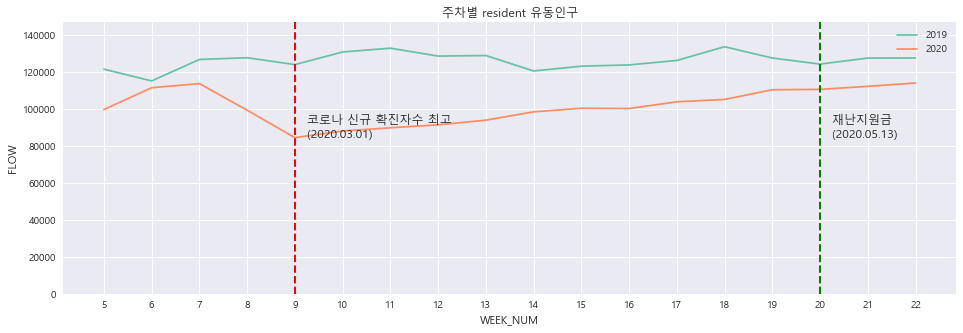

In [153]:
graph_by_weeknum('resident')

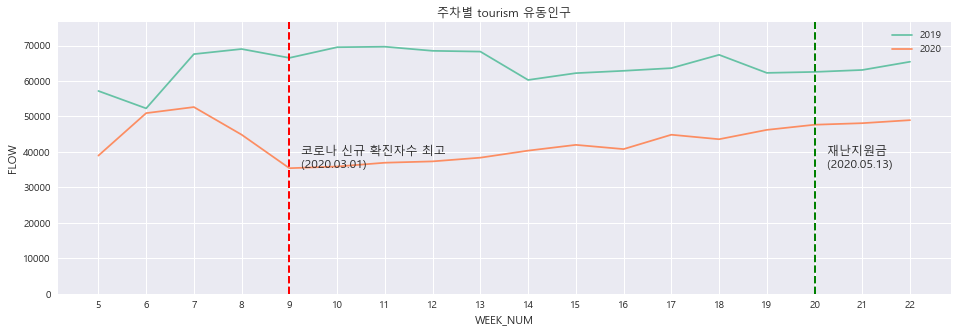

In [154]:
graph_by_weeknum('tourism')

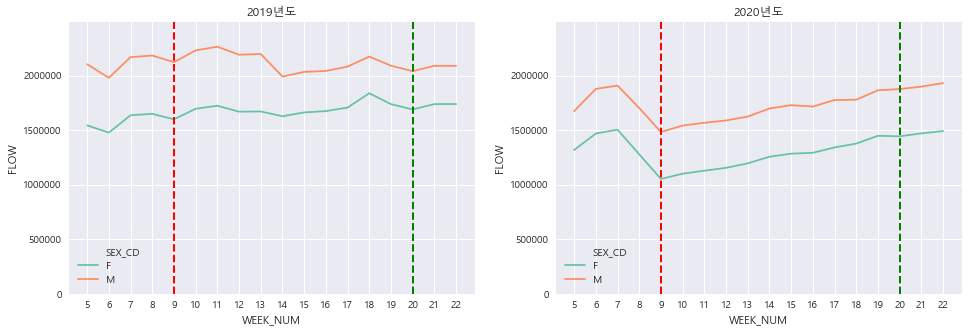

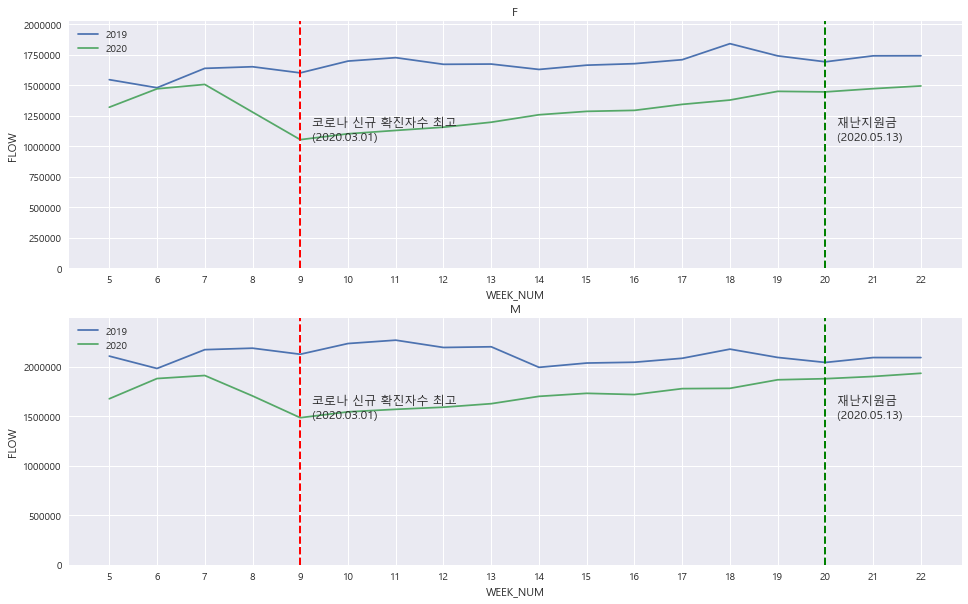

In [155]:
graph_by_weeknum_with_hue('resident','FLOW','SEX_CD')

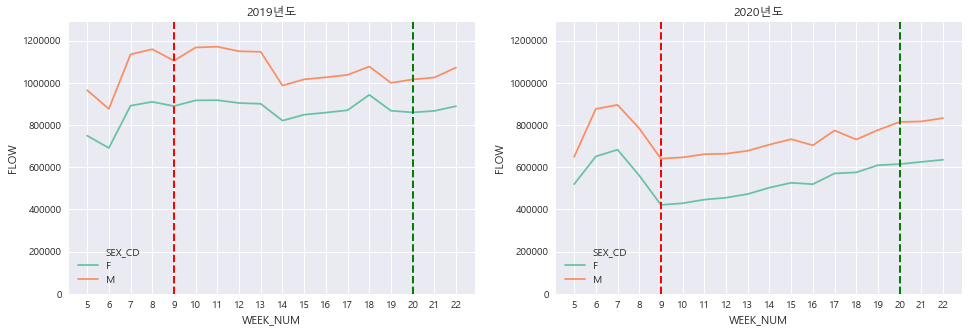

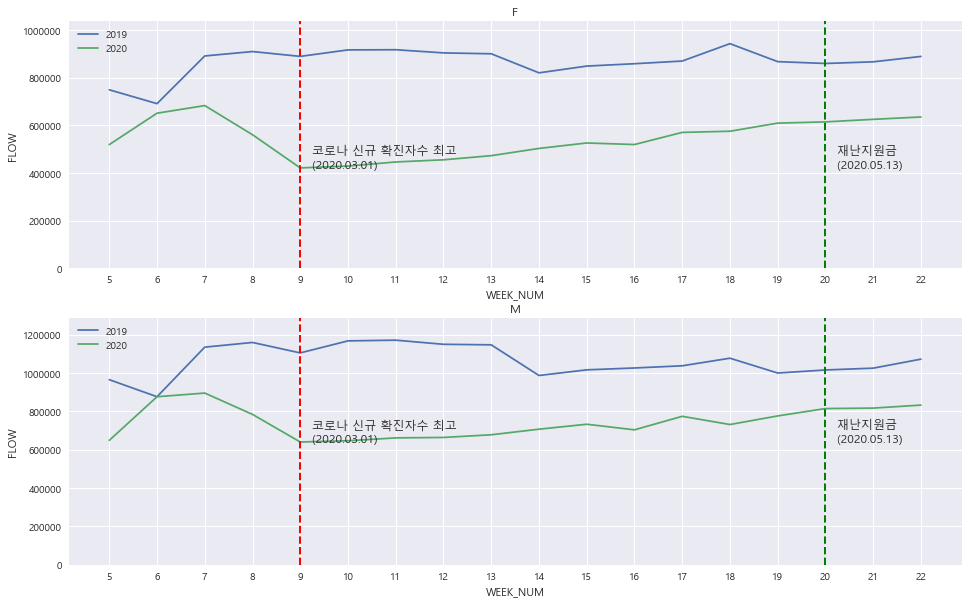

In [157]:
graph_by_weeknum_with_hue('tourism','FLOW','SEX_CD')

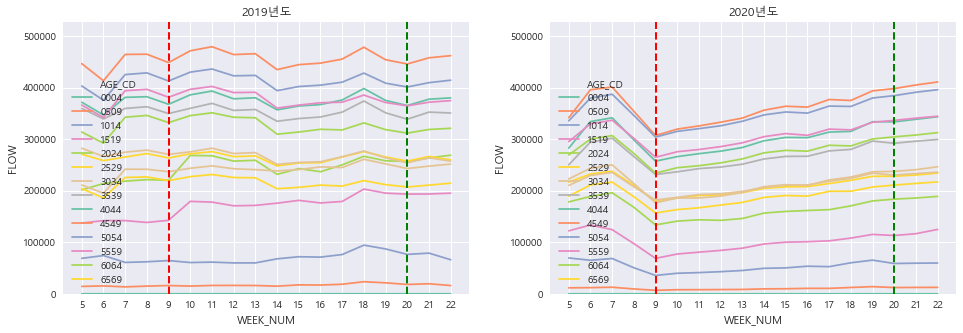

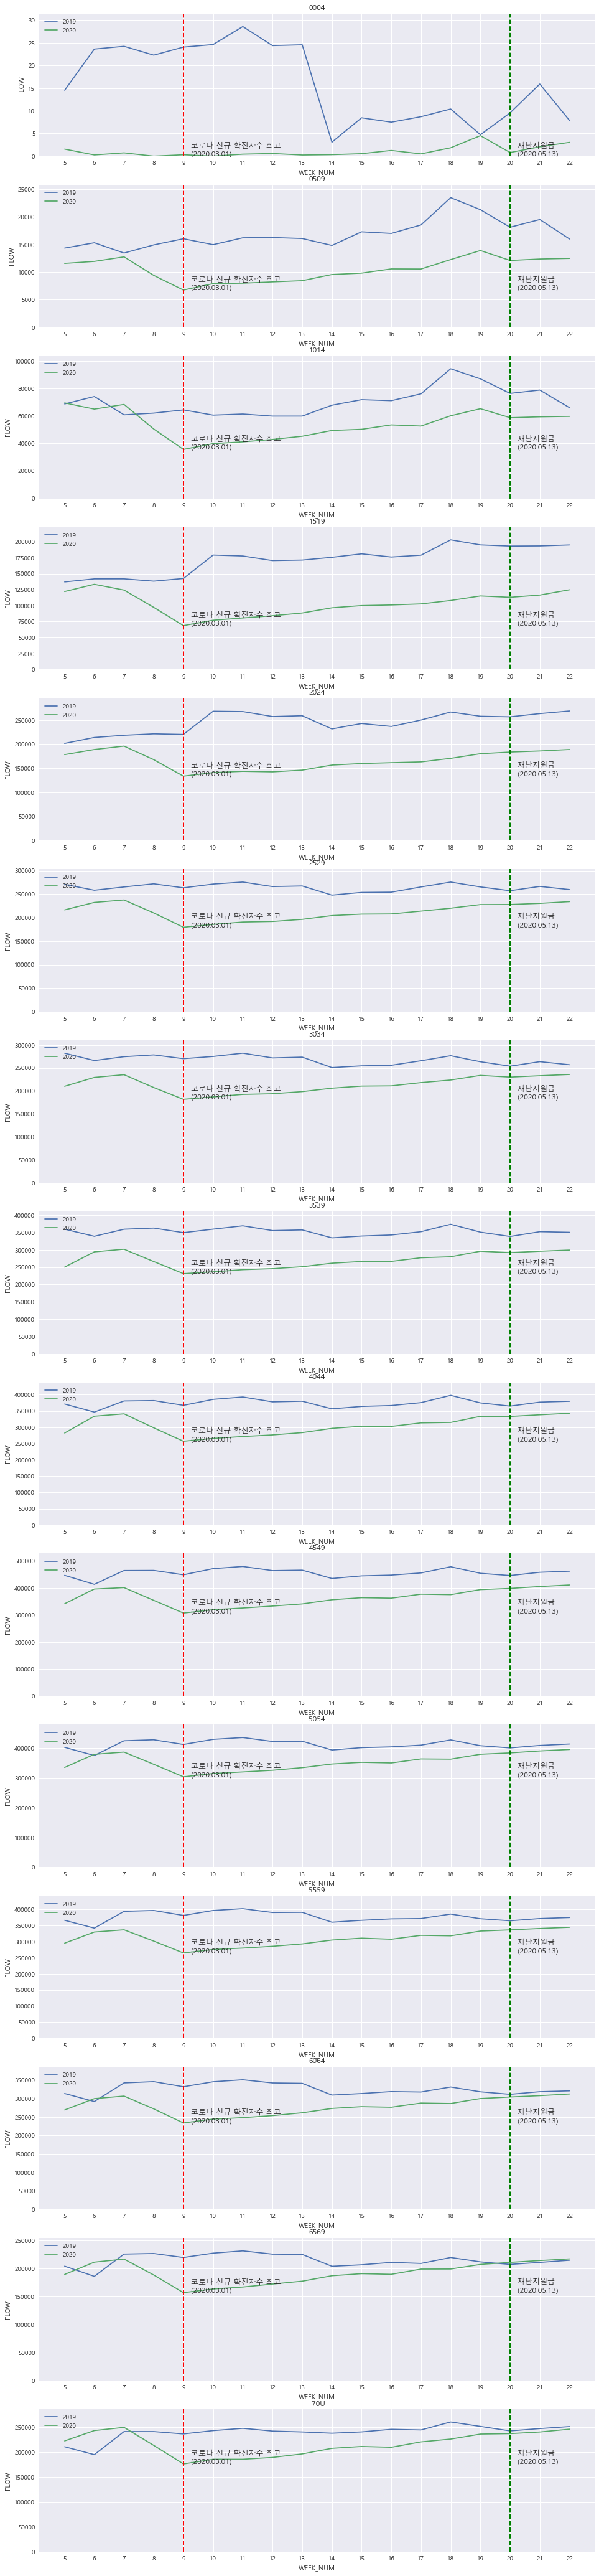

In [158]:
graph_by_weeknum_with_hue('resident','FLOW','AGE_CD')

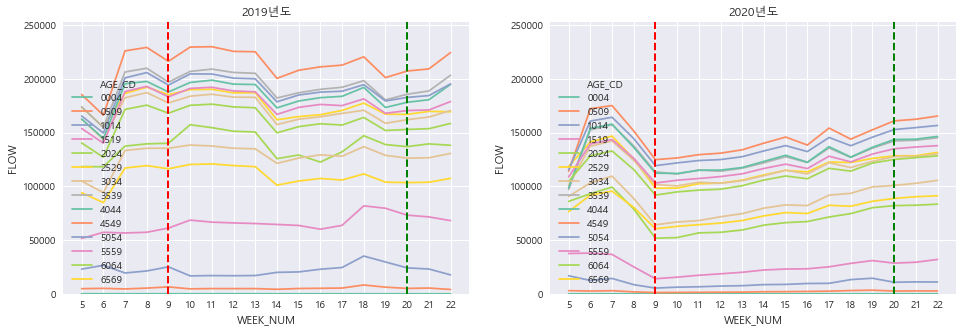

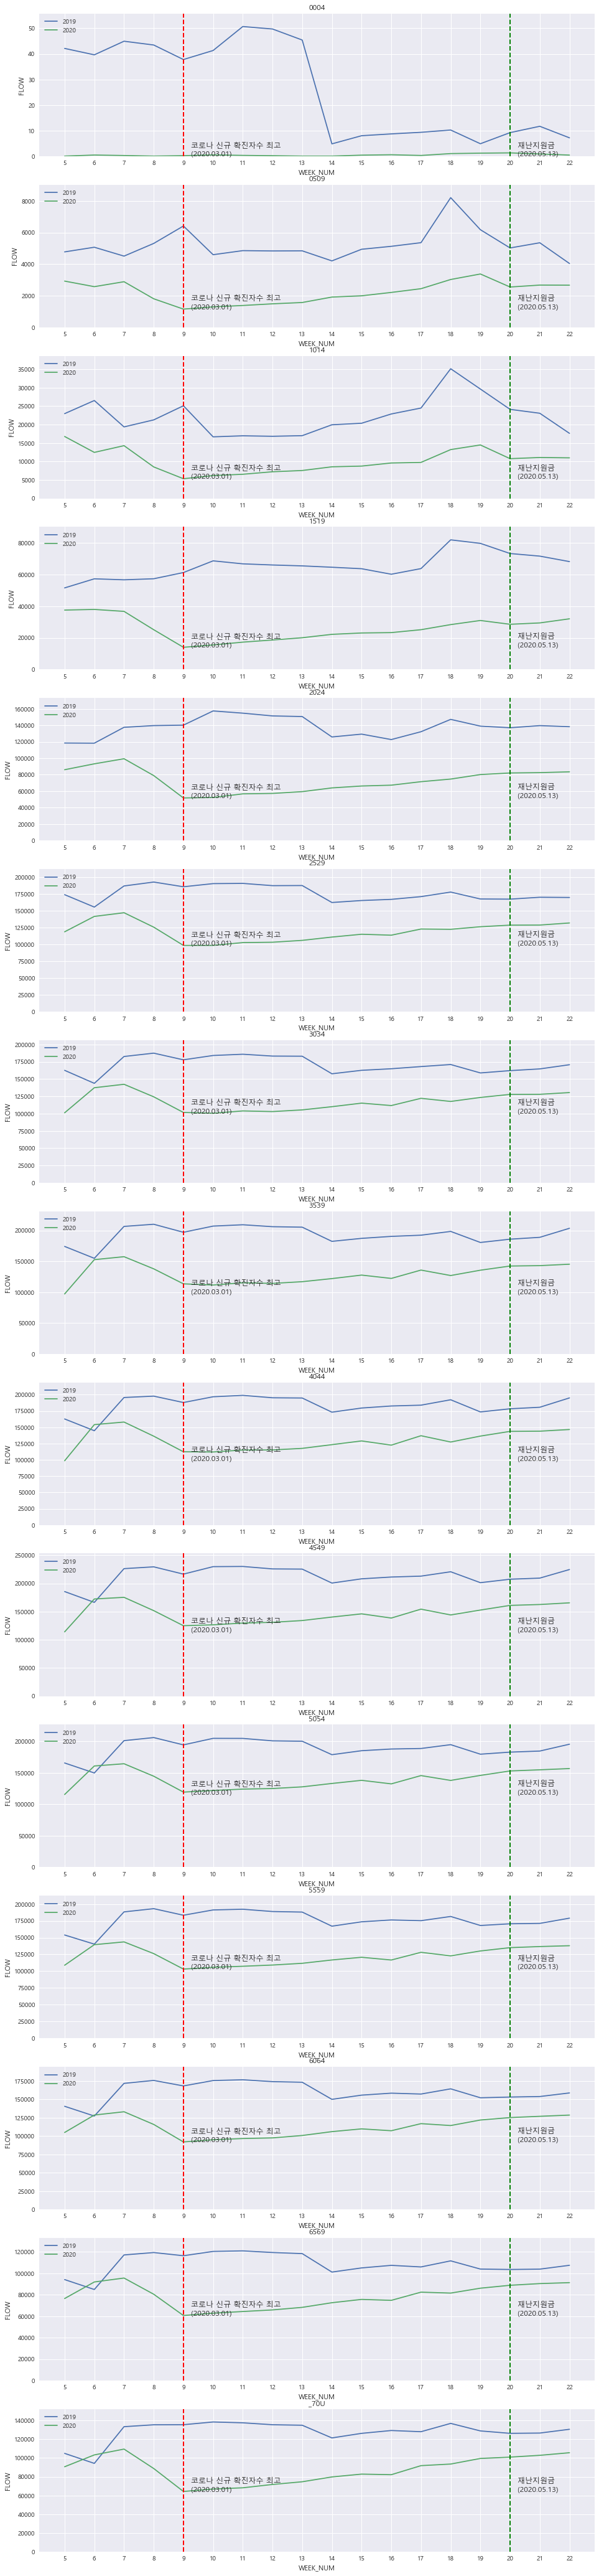

In [156]:
graph_by_weeknum_with_hue('tourism','FLOW','AGE_CD')

## 2. Time

Text(0.5, 1.0, '시간별 tourism 지역 유동인구')

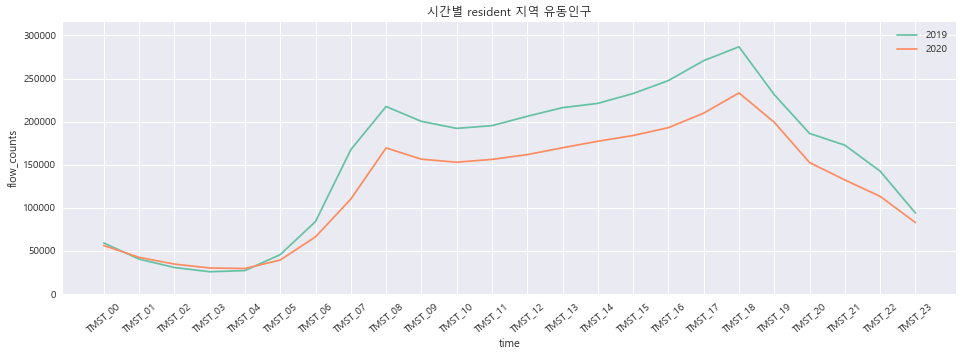

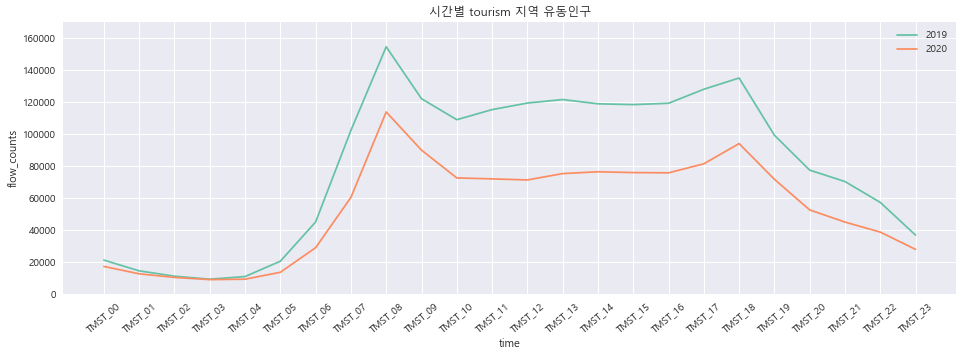

In [76]:
# 지역별 주별 평균을 구하고 -> 이것을 업종별로 합해서 그 업종 추이를 보고자 하였다
df = reti.query('resident == 1').groupby(['year', 'HDONG_NM', 'time'])[['flow_counts']].mean().reset_index()
df = df.groupby(['year', 'time'])[['flow_counts']].sum().reset_index()
    
plt.figure(figsize=(16, 5))
ax = sns.lineplot(x='time', y='flow_counts', hue='year', data=df, palette="Set2")
ax.set_xticks(list(df['time'].unique()))
ax.set_xticklabels(list(df['time'].unique()),rotation=40)
ax.legend([2019, 2020])
ax.set_ylim([0, df['flow_counts'].max()*1.1])
ax.set_title("시간별 resident 지역 유동인구", fontsize=12)


df = reti.query('tourism == 1').groupby(['year', 'HDONG_NM', 'time'])[['flow_counts']].mean().reset_index()
df = df.groupby(['year', 'time'])[['flow_counts']].sum().reset_index()
    
plt.figure(figsize=(16, 5))
ax = sns.lineplot(x='time', y='flow_counts', hue='year', data=df, palette="Set2")
ax.set_xticks(list(df['time'].unique()))
ax.set_xticklabels(list(df['time'].unique()),rotation=40)
ax.legend([2019, 2020])
ax.set_ylim([0, df['flow_counts'].max()*1.1])
ax.set_title("시간별 tourism 지역 유동인구", fontsize=12)

## 3. Month

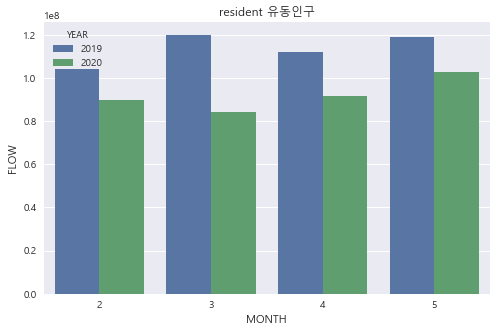

In [142]:
graph_by_year_month('resident')

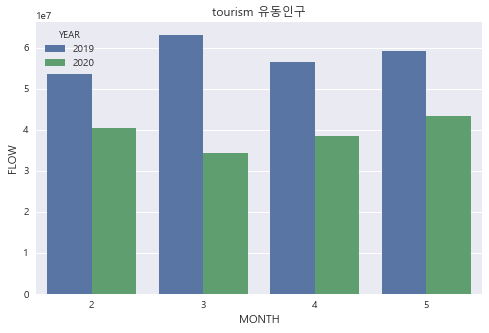

In [143]:
graph_by_year_month('tourism')

## 4. Weekday

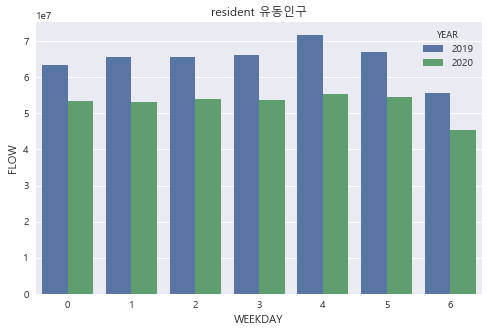

In [144]:
graph_by_year_weekday('resident')

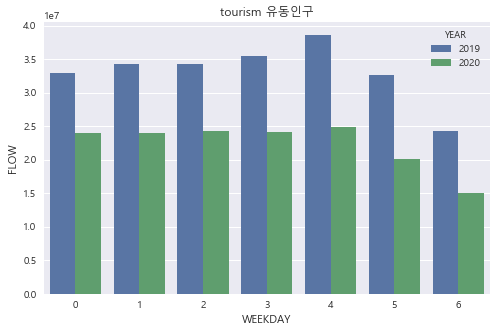

In [145]:
graph_by_year_weekday('tourism')

# 성별

## 1. 성별과 요일

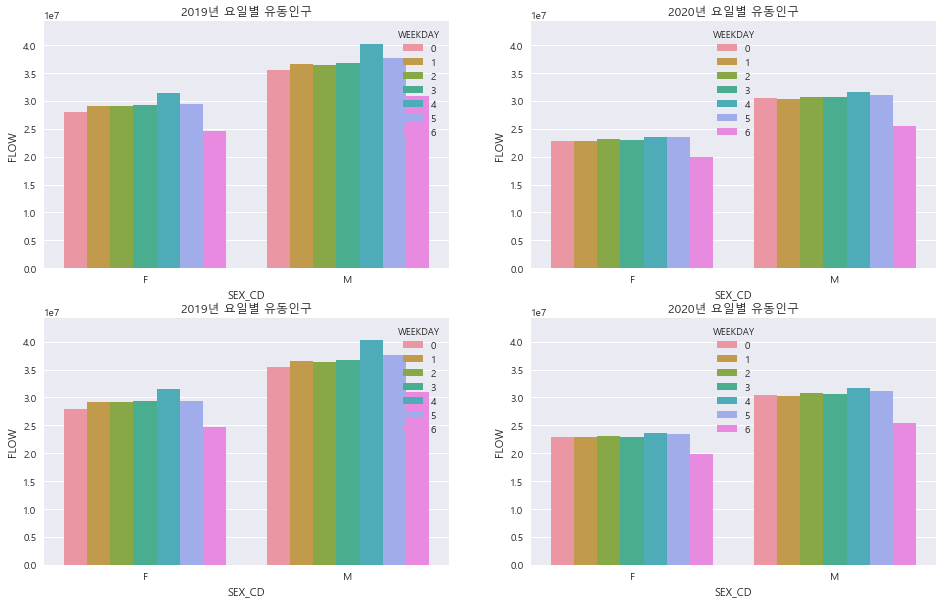

In [159]:
graph_by_weekday('resident','SEX_CD')

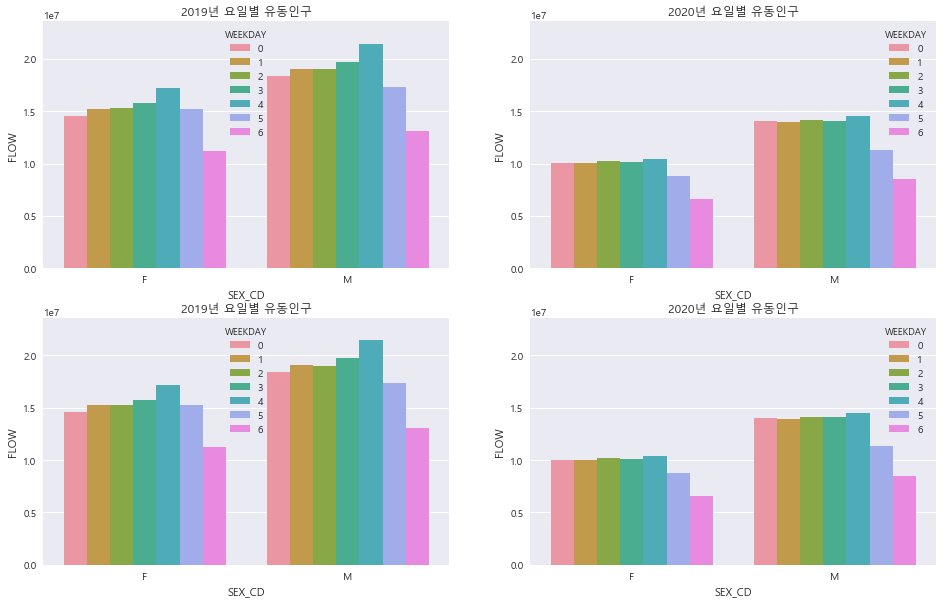

In [160]:
graph_by_weekday('tourism','SEX_CD')

## 2. 성별과 달

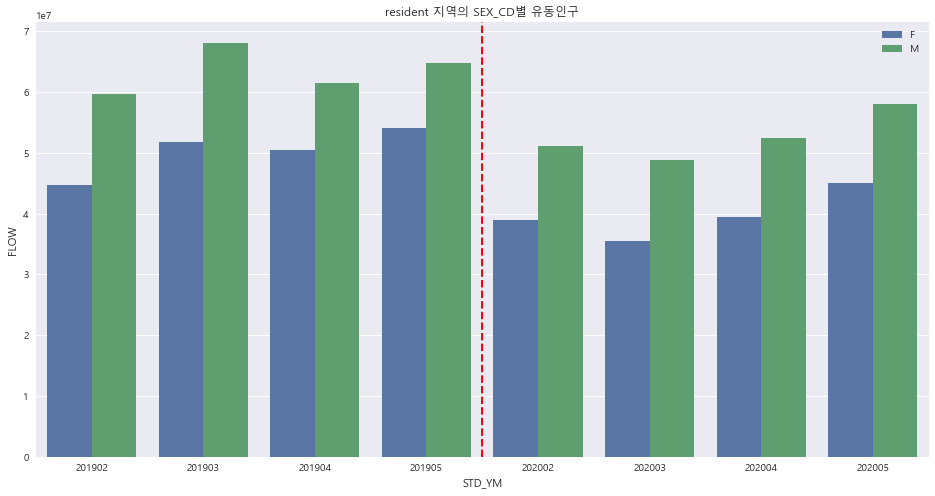

In [161]:
graph_by_yearmonth_withhue('resident','SEX_CD')

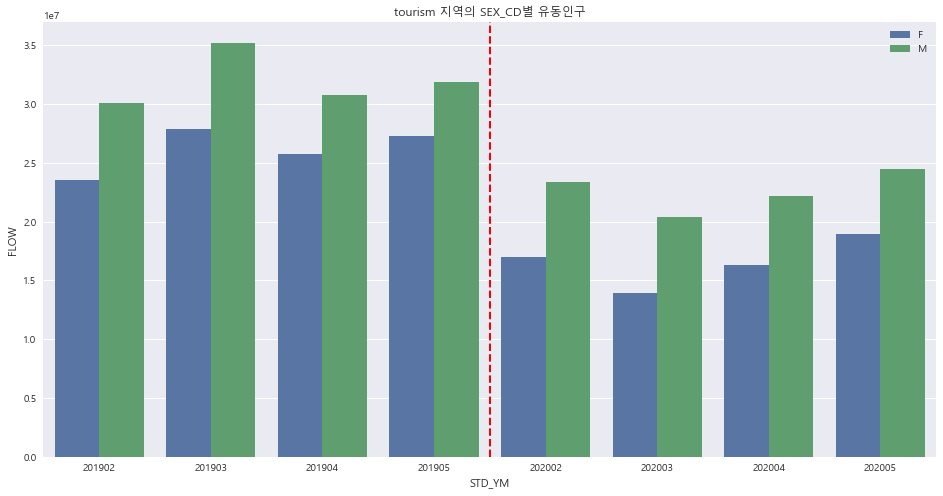

In [162]:
graph_by_yearmonth_withhue('tourism','SEX_CD')

# 나이

## 1. 나이와 달

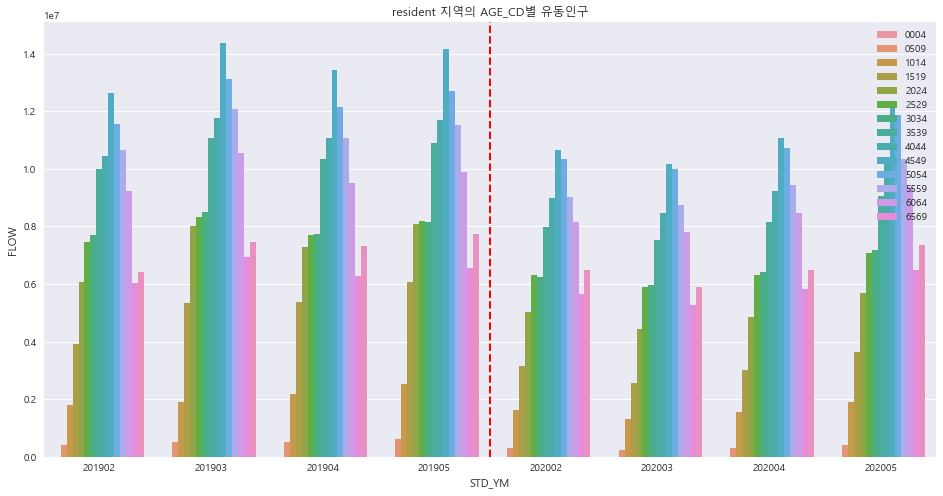

In [163]:
graph_by_yearmonth_withhue('resident','AGE_CD')

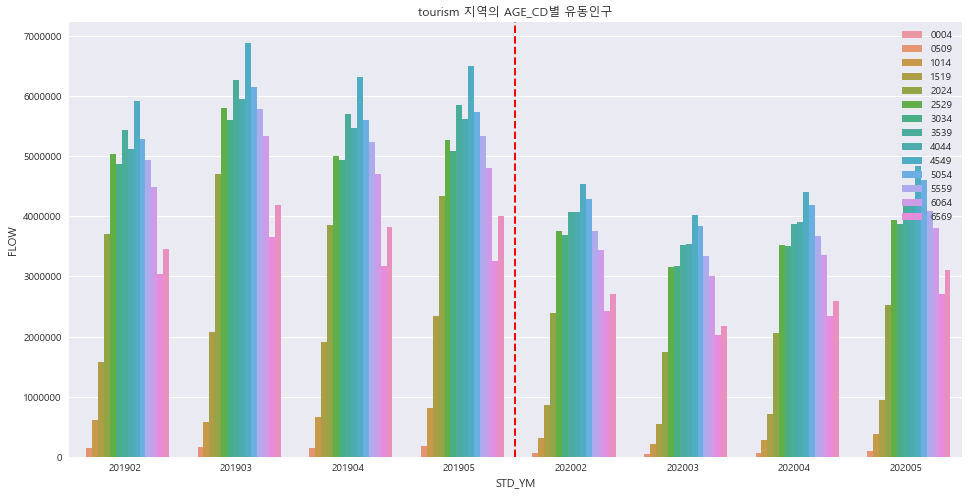

In [164]:
graph_by_yearmonth_withhue('tourism','AGE_CD')

## 2. 나이와 요일

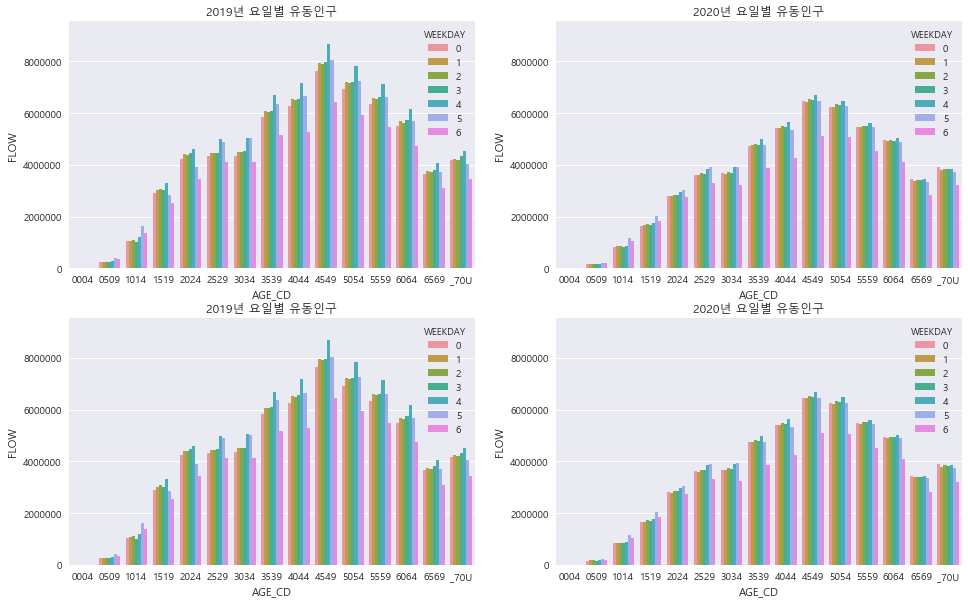

In [165]:
graph_by_weekday('resident','AGE_CD')

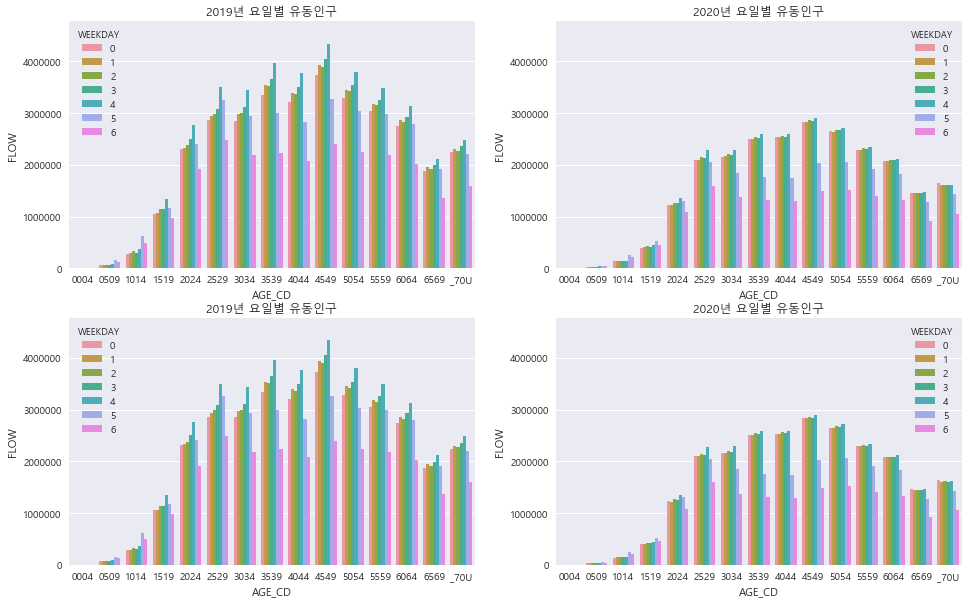

In [166]:
graph_by_weekday('tourism','AGE_CD')

--------------------

In [118]:
refl

,STD_YMD,STD_YM,YEAR,MONTH,WEEK_NUM,WEEKDAY,HDONG_NM,SEX_CD,AGE_CD,FLOW,resident,tourism,WEEKEND
0,2019-02-01,201902,2019,2,5,4_금,소공동,M,25,11195.62,0,0,0
1,2019-02-02,201902,2019,2,5,5_토,소공동,M,25,7592.34,0,0,1
2,2019-02-03,201902,2019,2,5,6_일,소공동,M,25,5173.35,0,0,1
3,2019-02-04,201902,2019,2,6,0_월,소공동,M,25,4641.82,0,0,0
4,2019-02-05,201902,2019,2,6,1_화,소공동,M,25,5478.30,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332575,2020-05-27,202005,2020,5,22,2_수,고산3동,F,65,2229.71,1,0,0
332576,2020-05-28,202005,2020,5,22,3_목,고산3동,F,65,2806.55,1,0,0
332577,2020-05-29,202005,2020,5,22,4_금,고산3동,F,65,2812.04,1,0,0
332578,2020-05-30,202005,2020,5,22,5_토,고산3동,F,65,2614.94,1,0,1
